In [9]:
import logging
logging.basicConfig(level=logging.WARNING)

import sys
sys.path.append('/Users/jankirschbaum/Documents/GitHub/py-utils')
sys.path.append('/Users/jankirschbaum/Documents/GitHub/D2/py-pde')
sys.path.append('/Users/jankirschbaum/Documents/GitHub/D2/Neu/py-phasesep/py-phasesep')
sys.path.append('/Users/jankirschbaum/Documents/GitHub/D2/py-droplets')

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import pde
import droplets
import phasesep

In [11]:
''' determine free energy density from interaction parameters '''
# The internal energies correspond to the slope of the two component free energy
wa, wb, wc = 0.,0.,0.
ws = np.array([wa,wb,wc])

# Chi is the interaction between droplet forming species B and the other two species
# The interaction is described by a matrix now, because each species interacts with every other
chi = 3.
chis = np.array([[0,chi,0],[chi,0,chi],[0,chi,0]])

# Define the free energy density for N=3 components using the interaction chi and internal energies w
f1 = phasesep.FloryHugginsNComponents(num_comp=3,chis=chis, internal_energies=ws)
f1.expression

'phi1 * log(phi1) + phi2 * log(phi2) + (1 - phi1 - phi2) * log(1 - phi1 - phi2) + 3 * phi1 * phi2 + 3 * phi2 * (1 - phi1 - phi2)'

[0.05437241273058322, 0.055077122008918726] 0.10944953473950195


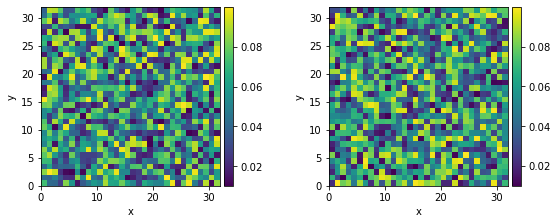

In [28]:
''' set the geometry '''
Lx, Ly = 32, 32
Nx, Ny = Lx, Ly
grid = pde.CartesianGrid([[0, Lx], [0, Ly]], [Nx,Ny], periodic=True)

x, y = grid.axes_coords[0], grid.axes_coords[1]

# The initial condition now needs two fields, one for A and one for B, C = 1 - A - B
phia, phib = pde.ScalarField.random_uniform(grid, 0.01,0.1), pde.ScalarField.random_uniform(grid, 0.01,0.1)

state = pde.FieldCollection([phia, phib])
print(state.averages, state.averages[0]+state.averages[1])
state.plot()

In [38]:
# Define the driving and the reaction rates
dmu = 12
rate1, rate2 = 1.e-4, 1.e-5

# Width of the Gaussian
s = 5

# Test includes the spatial dependecy of the reaction (example is a gaussian)
test = pde.ScalarField(grid)
for i in range(len(x)):
    for j in range(len(y)):
        test.data[i,j] = np.exp(-(x[i]-Lx/2)*(x[i]-Lx/2)/s) * np.exp(-(y[j]-Ly/2)*(y[j]-Ly/2)/s)
test.data*=rate2

# Define the reaction flux as a expression, k includes the spatial dependencies
rflux = f'k * ({dmu} + mu[0] - mu[1]) + {rate1} * (mu[0] - mu[1])'

# In the 3 component case one needs to define the stoichiometry (here (-1,1,0)) of the reaction
reaction = phasesep.Reaction([-1, 1, 0], rflux, consts={'k': test.data})
reactions = phasesep.Reactions(3, [reaction])

In [39]:
# Define the diffusive mobilities
mobilities = 1

In [40]:
'''  Define the equation that has to be solved '''
eq1 = phasesep.CahnHilliardMultiplePDE({'free_energy': f1, 'kappa_from_chis': True,
                                        'mobility': mobilities,'regularize_after_step':True,
                                        'reactions' : reactions, 'mobility_model' : 'const_direct'})

  0%|          | 0/200.0 [00:00<?, ?it/s]

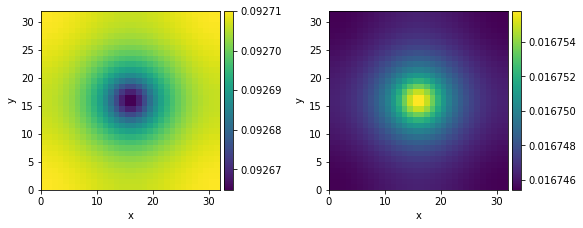

In [41]:
''' Solve the equation '''
t_range = 200  # time range of the simulation

result = eq1.solve(state, t_range=t_range, dt=1.e-3)
result.plot()